In [1]:
import time
import onnx
import torch
from torch.utils.data import DataLoader
import onnxruntime as ort
from onnxruntime.quantization import quantize_dynamic, quantize_static, CalibrationDataReader, QuantType
from onnxruntime.quantization.shape_inference import quant_pre_process
from pathlib import Path
import sys
import os
from hydra import initialize, compose

# Add project root to path
cur_dir = Path.cwd()
project_dir = cur_dir.parent
print(f"Project directory: {project_dir}")
sys.path.append(str(project_dir))

from data.kitti360.dataset import KittiSemSegDataset
from models.DinoFPNbn import DinoFPN
from src.compare import create_qat_model, load_qat_model

Project directory: /home/panos/dev/hf_seg


/home/panos/dev/hf_seg/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(onnx.__version__)

1.18.0


In [3]:
ort.get_device()

'CPU'

In [4]:
# Initialize config
with initialize(version_base=None, config_path="../configs", job_name="onnx_export"):
    cfg = compose(config_name="config")

In [5]:
# Create example input (batch_size=1, channels=3, height=364, width=1232)
B = 1
C = 3
example_input = torch.randn(B, C, cfg.augmentation.crop_height, cfg.augmentation.crop_width)

# Export paths
onnx_dir = project_dir / "onnx_models"
onnx_dir.mkdir(exist_ok=True)

In [11]:
fp32_checkpoint_path = project_dir / "checkpoints" / "dino-fpn-bn.pth"
fp32_onnx_path = onnx_dir / "fp32.onnx"

# Export Original FP32 Model

In [12]:
print("🔄 Loading and exporting original FP32 model...")
fp32_model = DinoFPN(num_labels=cfg.dataset.num_classes, model_cfg=cfg.model)
checkpoint = torch.load(fp32_checkpoint_path)
fp32_model.load_state_dict(checkpoint["model_state_dict"])
fp32_model.eval()

🔄 Loading and exporting original FP32 model...


DinoFPN(
  (backbone): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2LayerScale()
          

In [13]:
# Process input through model preprocessing
processed_input = fp32_model.process(example_input)
processed_input.shape

torch.Size([1, 3, 364, 1232])

In [14]:
# onnx_program = torch.onnx.export(
#     fp32_model, 
#     processed_input,
#     dynamo=True,
#     export_params=True,
#     do_constant_folding=True,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={
#         'input': {0: 'batch_size'},
#         'output': {0: 'batch_size'}
#     },
# )

In [15]:
# optimize ONNX model
# onnx_program.optimize()

In [16]:
# save the optimized ONNX model
# onnx_program.save(fp32_onnx_path)

In [17]:
# Load and check the exported ONNX model
onnx_model = onnx.load(fp32_onnx_path)
onnx.checker.check_model(onnx_model)
print("Model IR version:", onnx_model.ir_version)
print("Opset version:", onnx_model.opset_import[0].version)
print("ONNX model is valid.")
# I can also visualize the model using Netron: https://netron.app/

Model IR version: 10
Opset version: 18
ONNX model is valid.


In [18]:
# Execute the model using ONNX Runtime
print(processed_input.shape)
input = processed_input  # Add batch dimension
print("Input shape:", input.shape)

torch.Size([1, 3, 364, 1232])
Input shape: torch.Size([1, 3, 364, 1232])


In [19]:
# Create ONNX Runtime session
print(f"🔄 Creating ONNX Runtime session from {fp32_onnx_path}...")
ort_session = ort.InferenceSession(
    path_or_bytes=fp32_onnx_path, 
    providers=["CPUExecutionProvider"]
)

🔄 Creating ONNX Runtime session from /home/panos/dev/hf_seg/onnx_models/fp32.onnx...


In [20]:
# Prepare inputs for ONNX Runtime
input_name = ort_session.get_inputs()[0].name
onnxruntime_input = {input_name: input.numpy()}

print(f"Number of inputs: {len(onnxruntime_input)}")
first_input_shape = onnxruntime_input["input"].shape
print(f"First input shape: {first_input_shape}")

Number of inputs: 1
First input shape: (1, 3, 364, 1232)


In [21]:
# ONNXRuntime inference and time it
print("Running inference with ONNX Runtime...")
t0 = time.perf_counter()
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)[0]
t1 = time.perf_counter()
print(f"ONNX Runtime inference time: {t1 - t0:.6f} seconds")

Running inference with ONNX Runtime...
ONNX Runtime inference time: 2.928489 seconds


In [22]:
print(f"Number of outputs: {len(onnxruntime_outputs)}")
first_output_shape = onnxruntime_outputs[0].shape
print(f"First output shape: {first_output_shape}")

Number of outputs: 1
First output shape: (33, 364, 1232)


# Export QAT Quantized Model

In [19]:
# print("🔄 Loading and exporting QAT quantized model...")
# qat_model_path = project_dir / "checkpoints" / "dino-fpn-qat-int8.pth"
# qat_model = load_qat_model(qat_model_path, fp32_model)

In [20]:
# qat_input = processed_input.squeeze(0)  # Add batch dimension
# qat_input.shape

In [ ]:
# qat_onnx_path = onnx_dir / "dino_fpn_qat_int8.onnx"
# onnx_qat_program = torch.onnx.export(
#     qat_model, 
#     qat_input,
#     dynamo=True,
#     export_params=True,
#     opset_version=17,
#     do_constant_folding=False,
#     input_names=['input'],
#     output_names=['logits']
# )
# print(f"\nQAT model exported to {onnx_dir}")

In [ ]:
# # optimize ONNX model
# onnx_qat_program.optimize()

# # save the optimized ONNX model
# onnx_qat_program.save(qat_onnx_path)

# # Load and check the exported ONNX model
# onnx_qat_model = onnx.load(qat_onnx_path)
# onnx.checker.check_model(onnx_qat_model)

In [ ]:

# Create ONNX Runtime session
# ort_qat_session = ort.InferenceSession(
#     path_or_bytes=qat_onnx_path, 
#     providers=["CPUExecutionProvider"]
# )

# # ONNXRuntime inference and time it
# print("Running inference with ONNX Runtime...")
# t0 = time.perf_counter()
# onnxruntime_outputs = ort_qat_session.run(None, onnxruntime_input)[0]
# t1 = time.perf_counter()
# print(f"ONNX Runtime inference time: {t1 - t0:.6f} seconds")

# Quantize with ONNX

In [ ]:
# # Prepare the model for quantization
# model_prep_path = onnx_dir / "fp32_prep.onnx"
# quant_pre_process(
#     fp32_onnx_path, 
#     model_prep_path,
#     skip_symbolic_shape=True,
#     verbose=True,
# )

In [24]:
import albumentations as A

crop_h, crop_w = (cfg.augmentation.crop_height, cfg.augmentation.crop_width)

val_transform = A.Compose([
    A.CenterCrop(crop_h, crop_w)
])

cal_dataset = KittiSemSegDataset(
    root_dir='/home/panos/Documents/data/kitti-360',
    train=True,
    calibration=True,
    transform=val_transform
)
cal_loader = DataLoader(
    cal_dataset,
    batch_size=cfg.train.batch_size,
    shuffle=True,
    num_workers=cfg.dataset.num_workers,
    pin_memory=True,
)
print(f"[QuantPTQ] Calibration dataset size: {len(cal_dataset)}")

[QuantPTQ] Calibration dataset size: 704


In [ ]:
class QuantizationDataReader(CalibrationDataReader):
    def __init__(self, torch_dl, input_name):

        self.torch_dl = torch_dl
        self.input_name = input_name

        self.datasize = len(self.torch_dl)
        self.dl_iter = iter(self.torch_dl)

    def to_numpy(self, pt_tensor):
        return pt_tensor.detach().cpu().numpy() if pt_tensor.requires_grad else pt_tensor.cpu().numpy()

    def get_next(self):
        batch = next(self.dl_iter) # [2] [B, C, H, W] [B, H, W]
        imgs = batch[0]  # [B, C, H, W]
        masks = batch[1] # [B, H, W]
        processed_imgs = fp32_model.process(imgs) if batch is not None else None
        print("Batch shape:", processed_imgs.shape)
        if batch is not None:
          print(f"Type of processed_imgs: {type(processed_imgs)}")
          input = self.to_numpy(processed_imgs)
          print(f"[QuantPTQ] Input type: {type(input)}")
          print(f"[QuantPTQ] Input shape: {input.shape}")
          return {self.input_name: input}
        else:
          return None

    def rewind(self):
        self.dl_iter = iter(self.torch_dl)

input_name = ort_session.get_inputs()[0].name
qdr = QuantizationDataReader(cal_loader, input_name=input_name)

In [39]:
inputs = qdr.get_next()
print(f"Calibration data type: {type(inputs[qdr.input_name])}, dtype: {inputs[qdr.input_name].dtype}")

[QuantPTQ] Batch size: 2
torch.Size([12, 364, 1232, 3]) torch.Size([12, 364, 1232])
[QuantPTQ] Batch type: <class 'list'>
Batch shjape: torch.Size([12, 364, 1232, 3])
Batch shape: torch.Size([12, 3, 364, 1232])
Type of processed_batch: <class 'torch.Tensor'>
[QuantPTQ] Input type: <class 'numpy.ndarray'>
[QuantPTQ] Input shape: (12, 3, 364, 1232)
Calibration data type: <class 'numpy.ndarray'>, dtype: float32


In [23]:
q_static_opts = {"ActivationSymmetric":False,
                 "WeightSymmetric":True}
if torch.cuda.is_available():
    q_static_opts = {"ActivationSymmetric":True,
                    "WeightSymmetric":True}
print(q_static_opts)

{'ActivationSymmetric': True, 'WeightSymmetric': True}


In [24]:
for input_meta in ort_session.get_inputs():
    print(f"Input name: {input_meta.name}, type: {input_meta.type}")

Input name: input, type: tensor(float)


In [ ]:
model_prep_path = onnx_dir / "fp32_prep.onnx"
model_int8_path = onnx_dir / "int8.onnx"
quantized_model = quantize_static(model_input=model_prep_path,
                                  model_output=model_int8_path,
                                  calibration_data_reader=qdr,
                                  extra_options=q_static_opts)

Batch shape: torch.Size([1, 3, 364, 1232])
[QuantPTQ] Input shape: (1, 3, 364, 1232)


: 

# Inference


Processing image 1/783
Input shape: torch.Size([1, 3, 364, 1232])
Original Inference time: 2.4847 sec
Original mIoU = 0.7610
ONNX Runtime inference time: 3.2732 sec
ONNX Logits shape: (1, 33, 364, 1232)
ONNX Predictions shape: (1, 364, 1232)
ONNX mIoU = 0.7610
Image shape: torch.Size([364, 1232, 3])


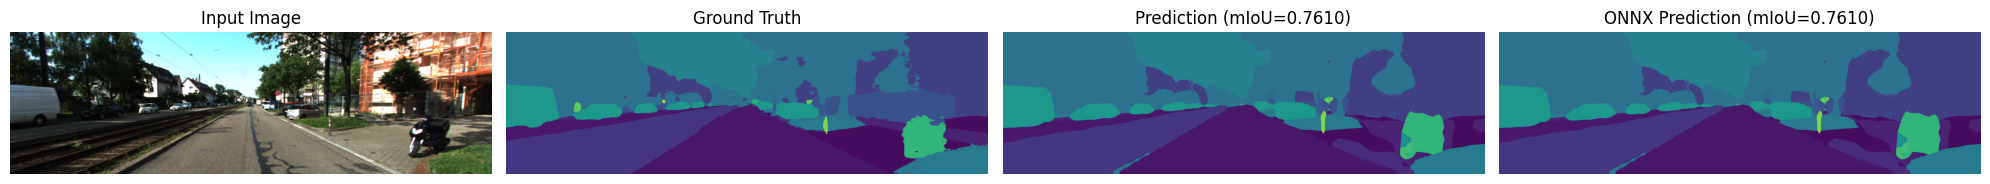

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import numpy as np
from torchmetrics import JaccardIndex
import albumentations as A

NUM_CLASSES = cfg.dataset.num_classes

dataset_root = '/home/panos/Documents/data/kitti-360'
val_transform = A.Compose([A.CenterCrop(cfg.augmentation.crop_height, cfg.augmentation.crop_width)])
val_dataset = KittiSemSegDataset(dataset_root, train=False, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

cmap = plt.get_cmap("viridis", NUM_CLASSES)
norm = BoundaryNorm(boundaries=np.arange(NUM_CLASSES + 1) - 0.5, ncolors=NUM_CLASSES)

# Metric: mean IoU
miou_metric = JaccardIndex(
    task='multiclass',
    num_classes=NUM_CLASSES,
    average='micro',
    ignore_index=None
)

fp32_model.eval()
with torch.no_grad():
    for idx, (imgs, masks) in enumerate(val_loader):
        masks = masks  # [B, H, W]
        imgs = imgs.permute(0, 3, 1, 2)  # [B, H, W, C] -> [B, C, H, W]
        input = fp32_model.process(imgs)  # Preprocess input for the model
        print(f"\nProcessing image {idx + 1}/{len(val_loader)}")

        # Forward pass with inference time
        t0 = time.perf_counter()
        print(f"Input shape: {input.shape}")
        logits = fp32_model(input)
        t1 = time.perf_counter()
        inference_time = t1 - t0
        print(f"Original Inference time: {inference_time:.4f} sec") # ~0.45 seconds

        # Compute mIoU for the current image
        preds = torch.argmax(logits, dim=1)  # [B, H, W]
        miou_metric.reset()
        miou_metric.update(preds, masks)
        miou = miou_metric.compute().item()
        print(f"Original mIoU = {miou:.4f}")

        # Prepare the input for ONNX Runtime
        processed_input = input.unsqueeze(0)  # Add batch dimension
        onnx_inputs = [tensor.numpy(force=True) for tensor in processed_input]
        onnxruntime_input = {input_arg.name: input_value for input_arg, input_value in zip(ort_session.get_inputs(), onnx_inputs)}

        # Forward pass with ONNX Runtime
        t2 = time.perf_counter()
        onnx_logits = ort_session.run(None, onnxruntime_input)[0]
        t3 = time.perf_counter()
        ort_inference_time = t3 - t2
        print(f"ONNX Runtime inference time: {ort_inference_time:.4f} sec")  # ~0.35 seconds
        print(f"ONNX Logits shape: {onnx_logits.shape}")

        # Extract predictions from ONNX logits
        onnx_preds = np.argmax(onnx_logits, axis=1)  # [B, H, W]
        onnx_preds = onnx_preds.astype(np.uint8)
        print(f"ONNX Predictions shape: {onnx_preds.shape}")

        # Compute mIoU for ONNX predictions
        miou_metric.reset()
        miou_metric.update(torch.tensor(onnx_preds), masks)
        onnx_miou = miou_metric.compute().item()
        print(f"ONNX mIoU = {onnx_miou:.4f}")

        # Plot the image, ground truth, and prediction
        img_np = imgs[0].permute(1, 2, 0)  # Convert to HWC format
        print(f"Image shape: {img_np.shape}")
        mask_np = masks[0]
        pred_np = preds[0]
        onnx_pred_np = onnx_preds[0]

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
        ax1.imshow(img_np)
        ax1.set_title("Input Image")
        ax1.axis("off")

        ax2.imshow(mask_np, cmap=cmap, norm=norm)
        ax2.set_title("Ground Truth")
        ax2.axis("off")

        ax3.imshow(pred_np, cmap=cmap, norm=norm)
        ax3.set_title(f"Prediction (mIoU={miou:.4f})")
        ax3.axis("off")

        ax4.imshow(onnx_pred_np, cmap=cmap, norm=norm)
        ax4.set_title(f"ONNX Prediction (mIoU={onnx_miou:.4f})")
        ax4.axis("off")

        plt.tight_layout()
        plt.show()  # Wait for the user to close the plot before continuing

        break